**Goal**

Modify the existing U-net based architecture of DeepFinder to solve a pretext task of reconstructing images with missing random patches.

In this case our input are images with missing random patches and the objetive would be the original grayscale image. This is a regression problem and the loss we will use is the L2 reconstruction loss.

Steps:

1. Modify the dataloader to read patches with missing center
2. Change loss function to L2 reconstruction loss
3. Last layer of the network must be adapted for a regression problem
4. 

In [1]:
from jeroHelper.setupUtils import append_deepfinder_path, get_tomo_indices, PARENT_PATH
append_deepfinder_path()

tomo_ids, tomo_idx = get_tomo_indices()
print('\n')

from jeroHelper.coordGen import make_random_xml_objlist_from_crops, make_xml_objlist_from_crops
from jeroHelper.trainHelper import make_trainer

from deepfinder.training_pylit import TargetBuilder
from deepfinder.dataloader_pylit import DeepFinder_dataset, to_categorical, transpose_to_channels_first, PretextDeepFinder_dataset
from deepfinder.model_pylit import DeepFinder_model
import deepfinder.utils.objl as ol

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd

from torch.utils.data import DataLoader, Dataset
from deepfinder.utils import core
import torch


%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

Pairs of tomo IDs to indices:
[('tomo02', 0), ('tomo03', 1), ('tomo04', 2), ('tomo10', 3), ('tomo17', 4), ('tomo32', 5), ('tomo38', 6)]




# Working example

In [2]:
### This only makes sense if ONE crop of each tomogram is used
path_data = []
path_target = []
for tomo_id, deepFinder_idx in zip(tomo_ids, tomo_idx):

    file_data = PARENT_PATH+'data/processed0/nnUnet/cET_cropped/%s_bin4_denoised_0000_309-618_309-618_100-350.mrc' %tomo_id
    file_target = PARENT_PATH+'data/processed0/nnUnet/cET_cropped/%s_merged_thr02_lbl_309-618_309-618_100-350.mrc' %tomo_id
    
    path_data+=[file_data]
    path_target+=[file_target]
    
path_objl_train = '../data/processed0/deepFinder/object_lists/train_tomo02-03-04-17_309-618_309-618_100-350.xml'

path_objl_valid = '../data/processed0/deepFinder/object_lists/validation_tomo10-32_309-618_309-618_100-350.xml'

# Load object lists:
objl_train = ol.read_xml(path_objl_train)
objl_valid = ol.read_xml(path_objl_valid)

0.25592041015625


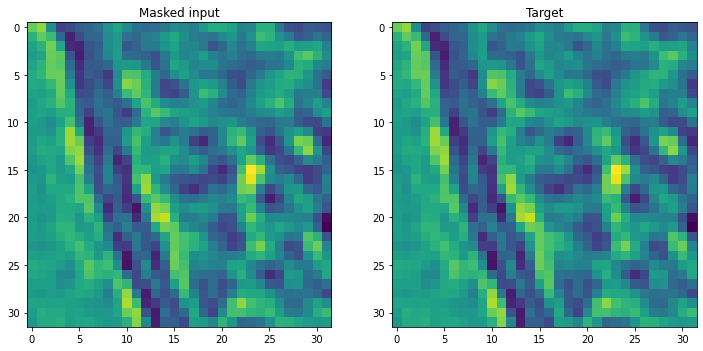

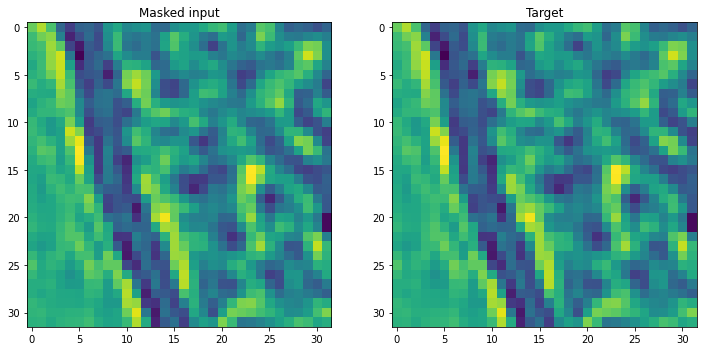

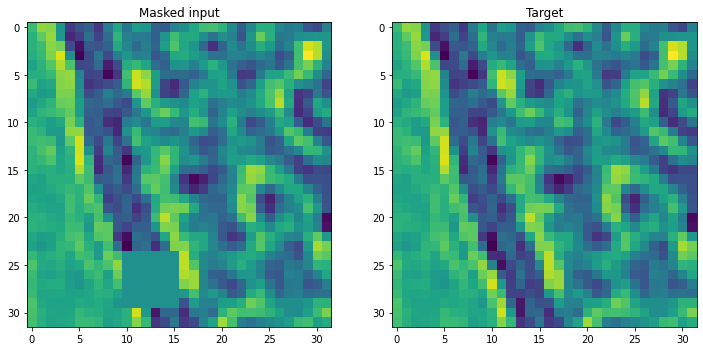

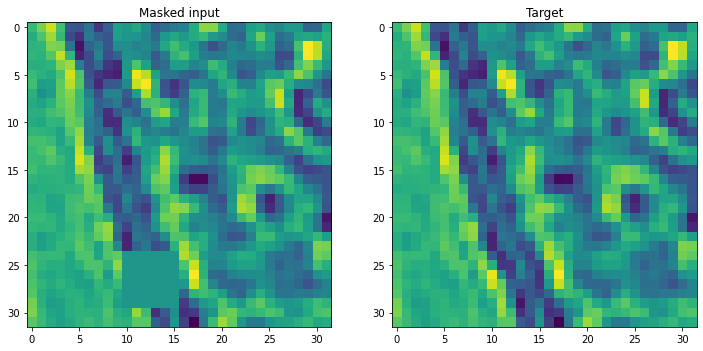

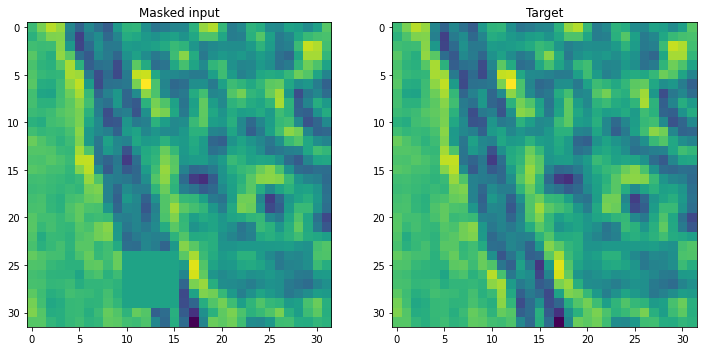

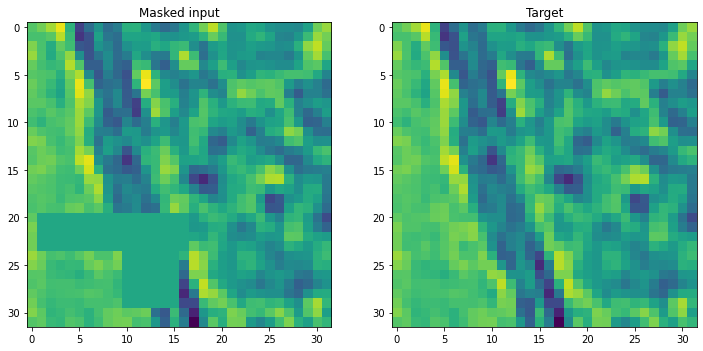

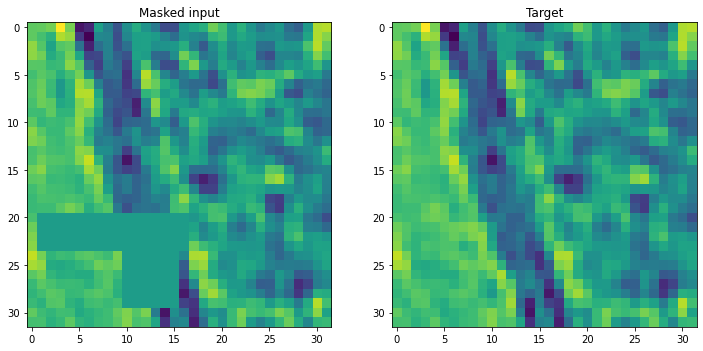

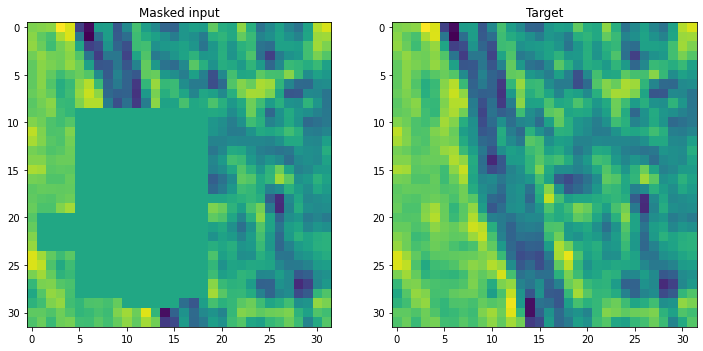

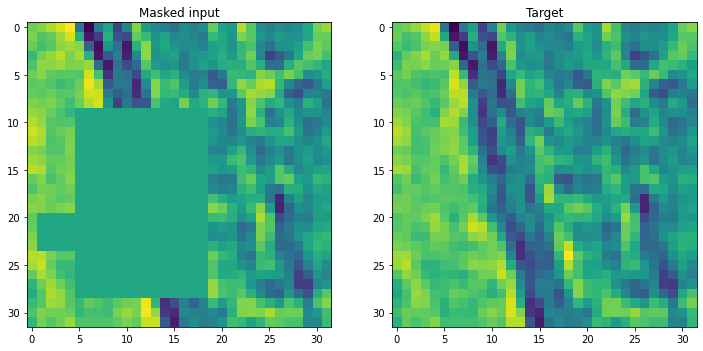

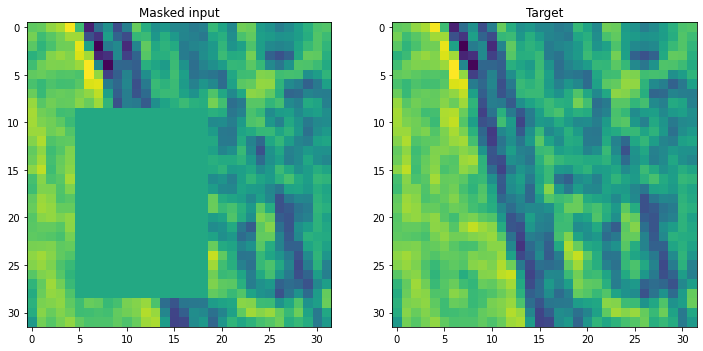

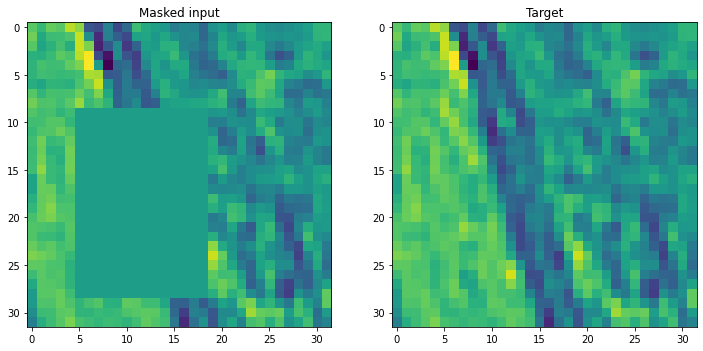

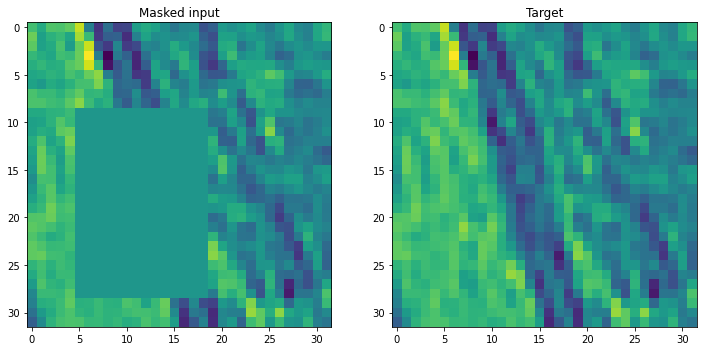

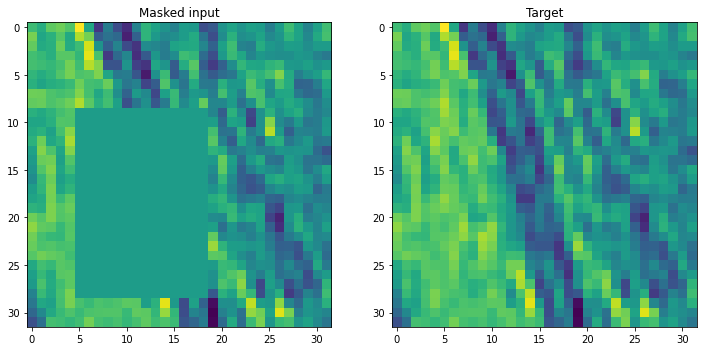

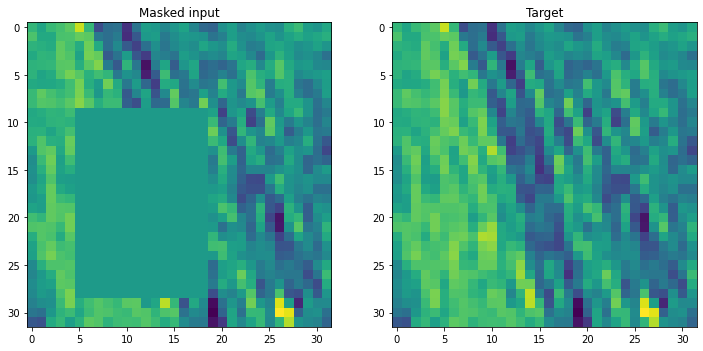

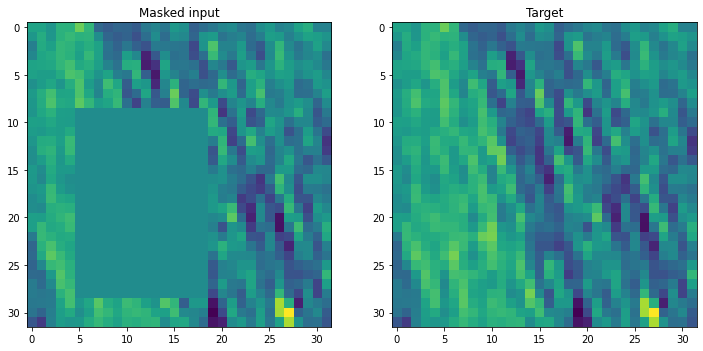

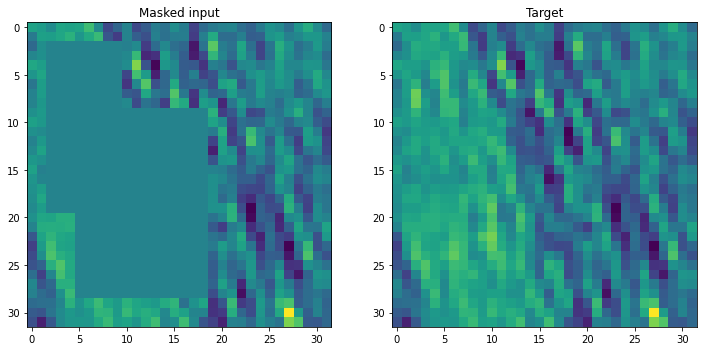

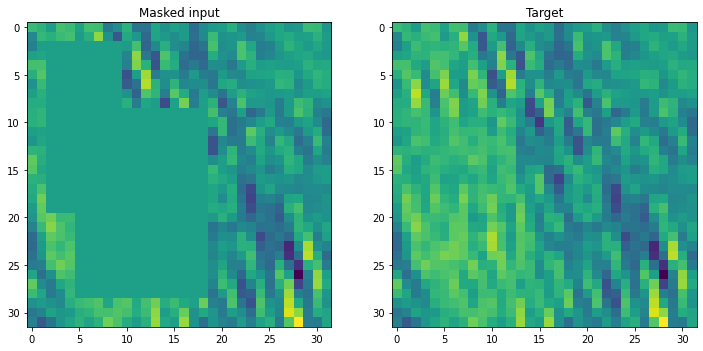

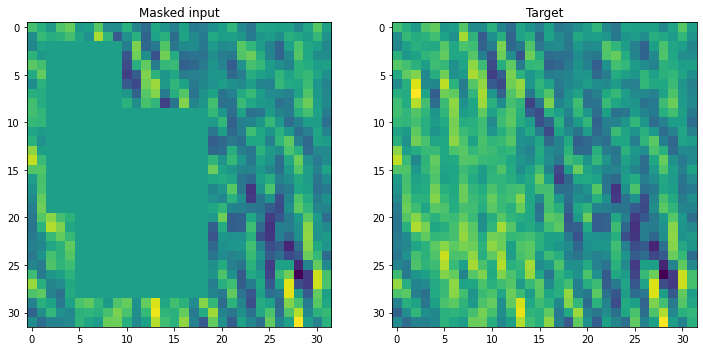

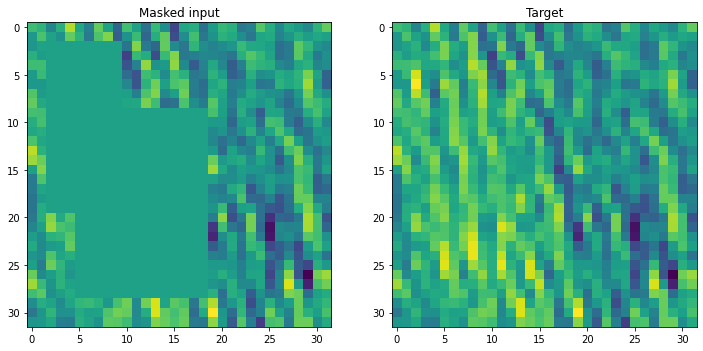

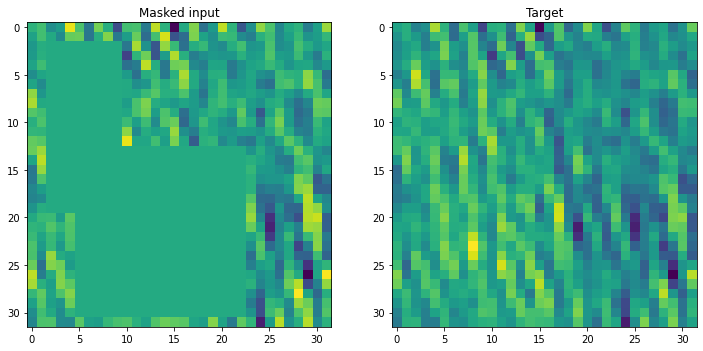

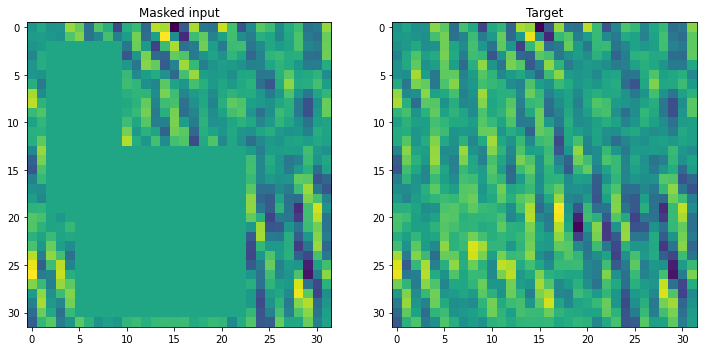

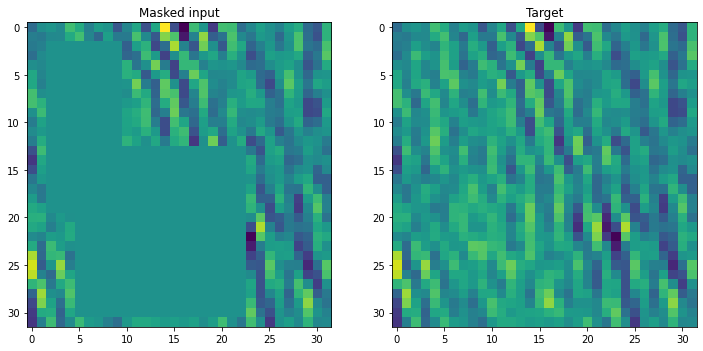

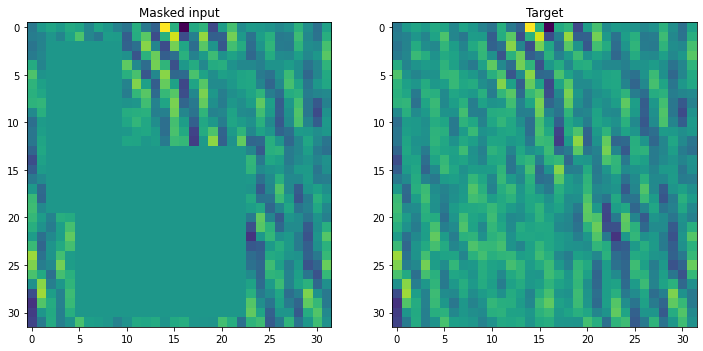

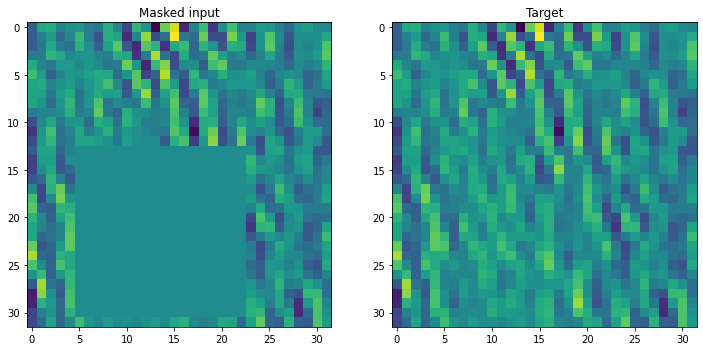

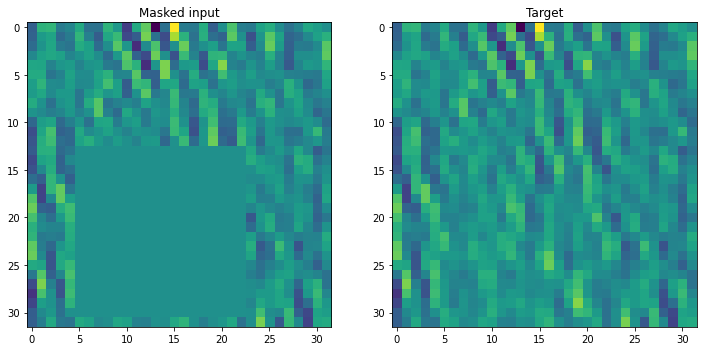

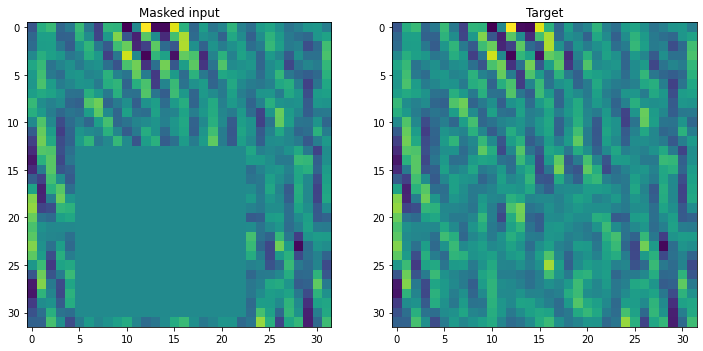

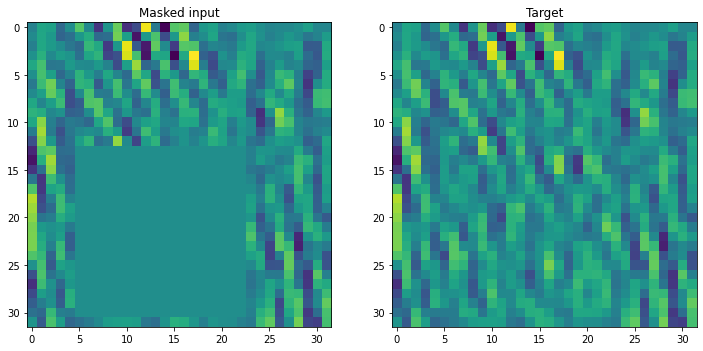

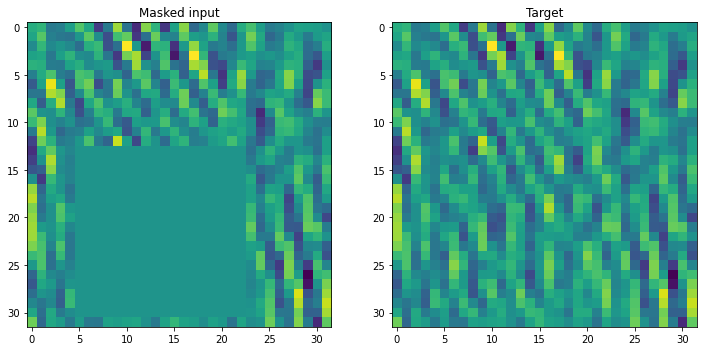

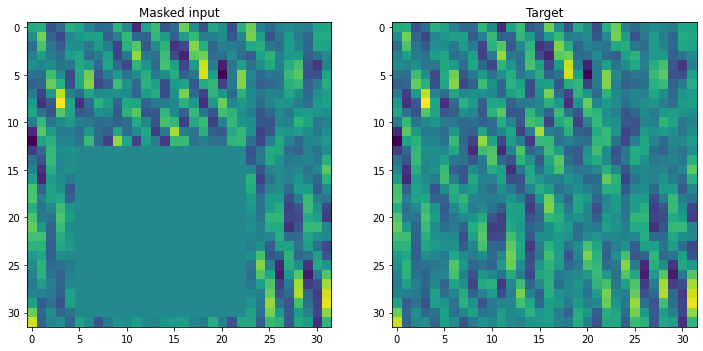

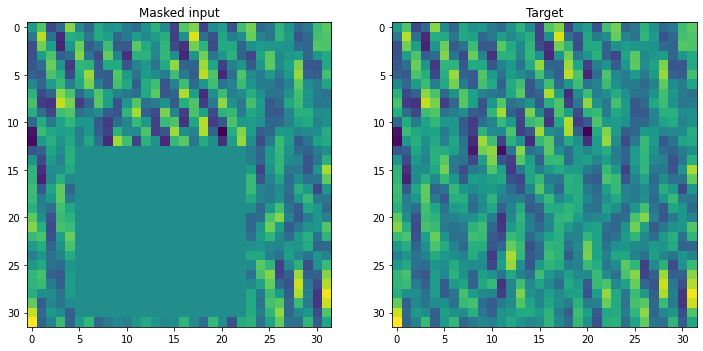

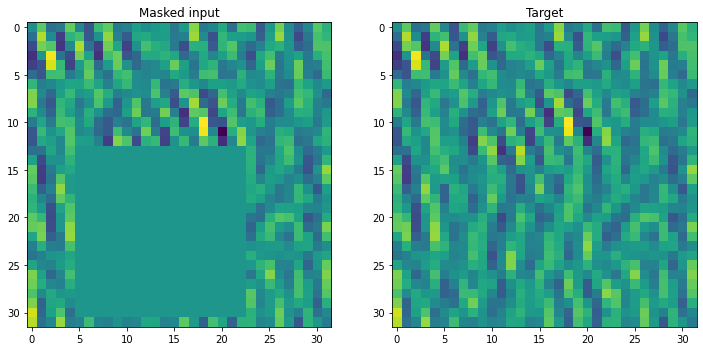

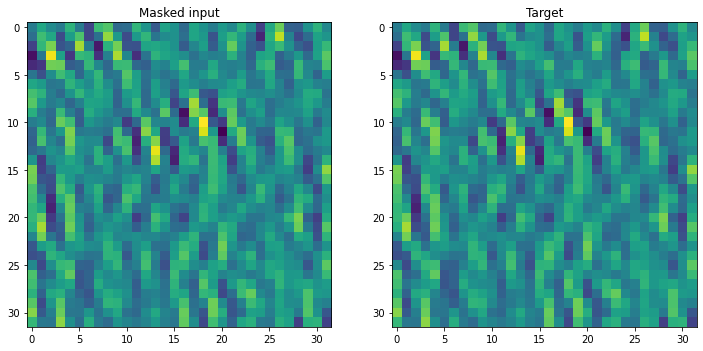

In [13]:
dim_in = 32
mask_pct = 0.4

train_set = PretextDeepFinder_dataset(False, path_data, path_target, objl_train, dim_in, 0, 'dataset', mask_pct)
batch_data, batch_target = train_set.generate_batch_from_array(3)

sample_data = batch_data[0]
sample_target = batch_target[0]

n = int((batch_data.flatten() == 0).sum())
d = len(batch_data.flatten())

print(n/d)

for z_idx in range(32):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

    ax1.imshow(sample_data[z_idx])
    ax1.set_title('Masked input')
    ax2.imshow(sample_target[z_idx])
    ax2.set_title('Target')

    plt.show()

0.211456298828125

# Dataloader

In [2]:
class PretextDeepFinder_dataset(Dataset):
    def __init__(self, flag_direct_read, path_data, path_target, objlist, dim_in, Lrnd, h5_dset_name, mask_pct):
        self.flag_direct_read = flag_direct_read
        self.path_data = path_data
        self.path_target = path_target
        self.objlist = objlist
        self.dim_in = dim_in
        self.p_in = np.int(np.floor(self.dim_in / 2))
        self.Lrnd = Lrnd
        
        assert mask_pct < 0.8
        assert mask_pct >= 0
        
        self.mask_pct = mask_pct
        if not self.flag_direct_read:
            self.data_list, self.target_list = core.load_dataset(self.path_data, self.path_target, h5_dset_name)

    def __len__(self):
        return len(self.objlist)

    def __getitem__(self, idx):
        if self.flag_direct_read:
            return self.generate_batch_direct_read(idx)
        else:
            return self.generate_batch_from_array(idx)


    def generate_batch_from_array(self, index):
        batch_data = torch.zeros((self.dim_in, self.dim_in, self.dim_in, 1))
        batch_target = torch.zeros((self.dim_in, self.dim_in, self.dim_in, 1))
        
        tomoID = int(self.objlist[index]['tomo_idx'])

        tomodim = self.data_list[tomoID].shape

        sample_data = self.data_list[tomoID]

        # Get patch position:
        x, y, z = core.get_patch_position(tomodim, self.p_in, self.objlist[index], self.Lrnd)

        # Get patch:
        patch_data = sample_data[z - self.p_in:z + self.p_in, y - self.p_in:y + self.p_in, x - self.p_in:x + self.p_in]

        # Process the patches in order to be used by network:
        patch_data = (patch_data - torch.mean(patch_data)) / torch.std(patch_data)  # normalize

        # Store into batch array:
        batch_data[:, :, :, 0] = patch_data
        
        ### Disable data augmentation to run overfitting to one sample
        # Data augmentation (180degree rotation around tilt axis):
        if np.random.uniform() < 0.5:
            batch_data = torch.rot90(batch_data, k=2, dims=(0, 2))
            batch_target = torch.rot90(batch_target, k=2, dims=(0, 2))
        
        batch_data = transpose_to_channels_first(batch_data)        
        batch_target = torch.clone(batch_data)
        
        # the masking is carried out at the very end and done in every direction with the same proportion
        # The idea is to distribute a total amount of pixels in random squares
        
        n_pixel = np.round(self.dim_in*np.power(self.mask_pct, 1/3))//2
        n_pixel = int(n_pixel)
        img_center = self.dim_in//2

        batch_data[0, img_center-n_pixel:img_center+n_pixel, img_center-n_pixel:img_center+n_pixel, img_center-n_pixel:img_center+n_pixel] = 0
        
        return batch_data, batch_target

In [2]:
### This only makes sense if ONE crop of each tomogram is used
path_data = []
path_target = []
for tomo_id, deepFinder_idx in zip(tomo_ids, tomo_idx):

    file_data = PARENT_PATH+'data/processed0/nnUnet/cET_cropped/%s_bin4_denoised_0000_309-618_309-618_100-350.mrc' %tomo_id
    file_target = PARENT_PATH+'data/processed0/nnUnet/cET_cropped/%s_merged_thr02_lbl_309-618_309-618_100-350.mrc' %tomo_id
    
    path_data+=[file_data]
    path_target+=[file_target]
    
path_objl_train = '../data/processed0/deepFinder/object_lists/train_tomo02-03-04-17_309-618_309-618_100-350.xml'

path_objl_valid = '../data/processed0/deepFinder/object_lists/validation_tomo10-32_309-618_309-618_100-350.xml'

# Load object lists:
objl_train = ol.read_xml(path_objl_train)
objl_valid = ol.read_xml(path_objl_valid)

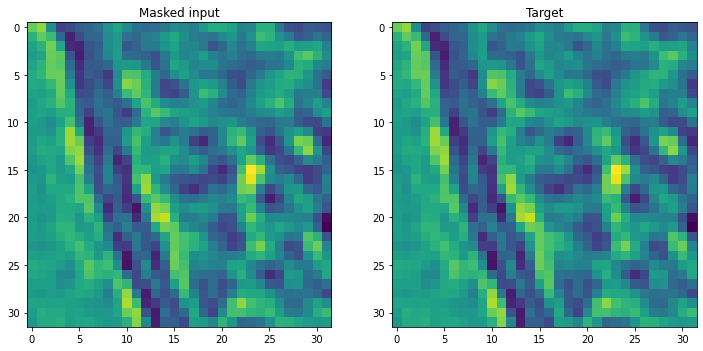

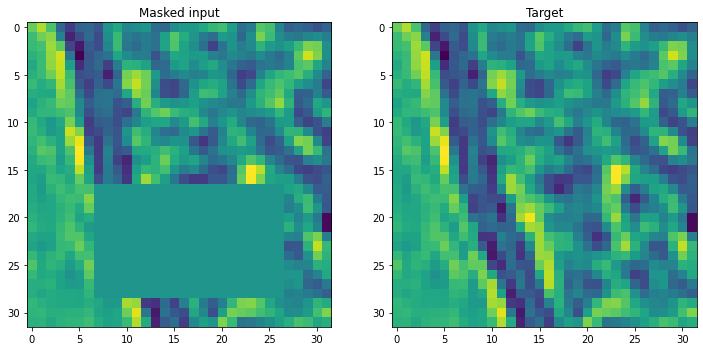

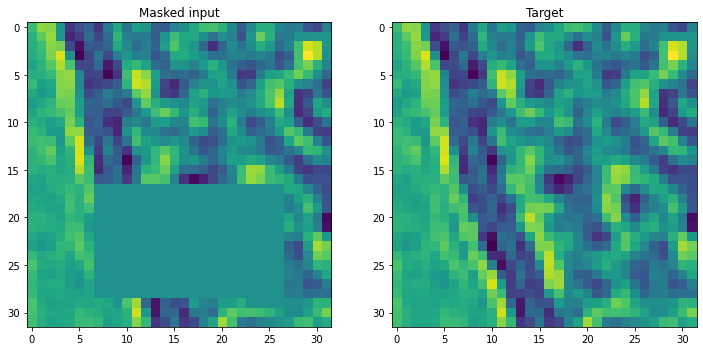

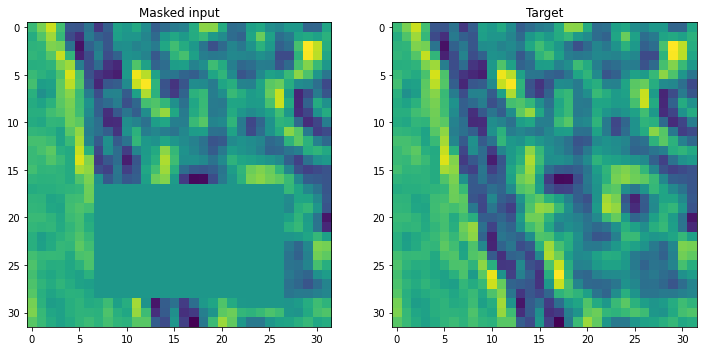

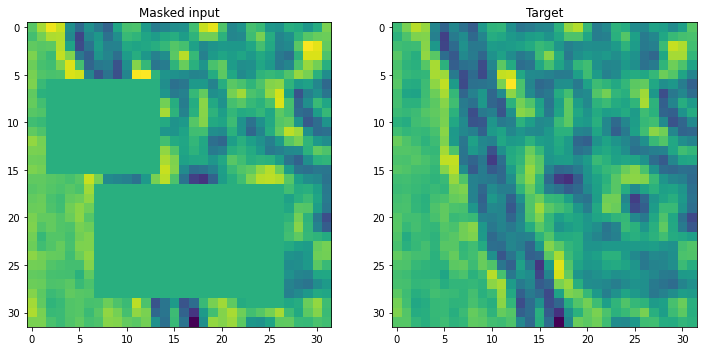

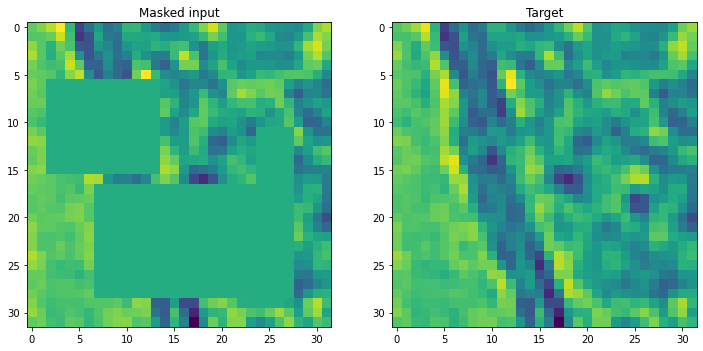

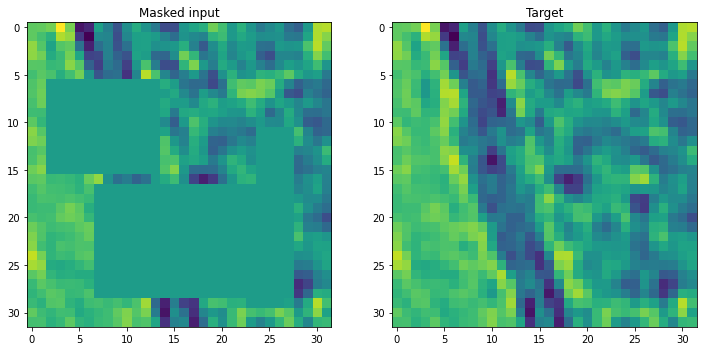

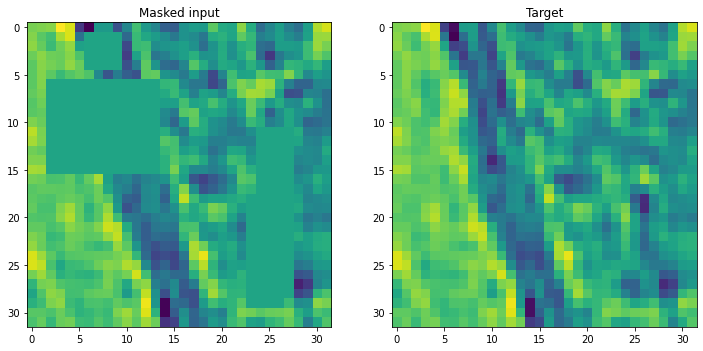

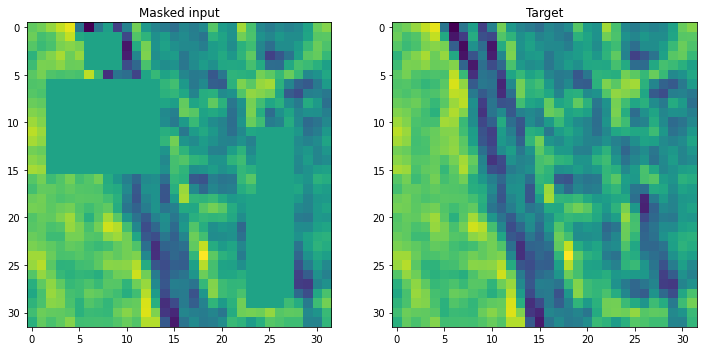

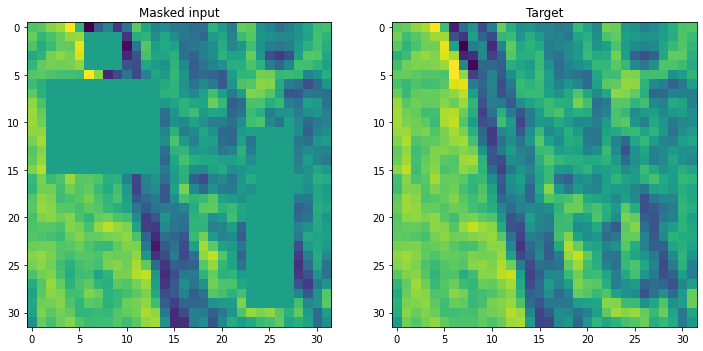

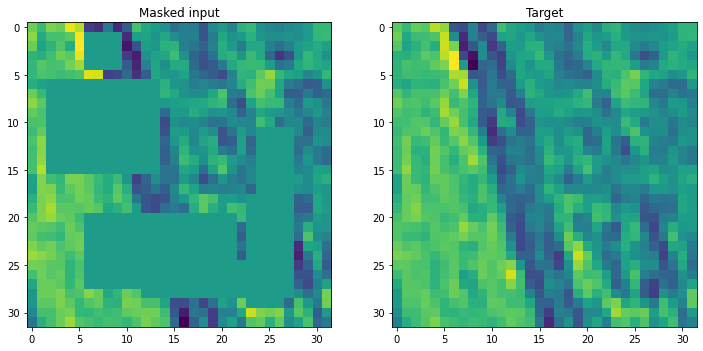

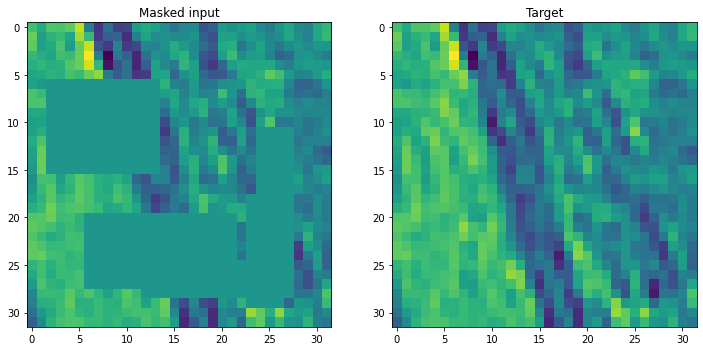

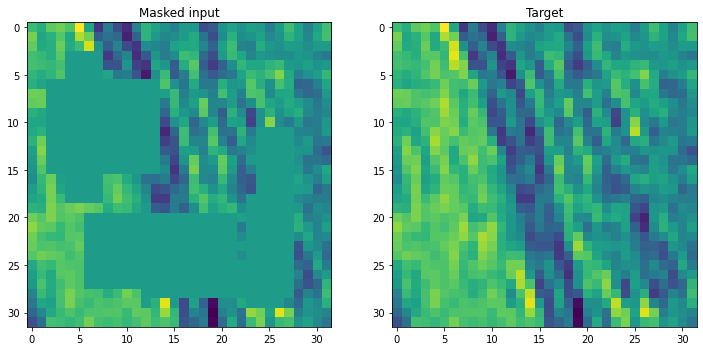

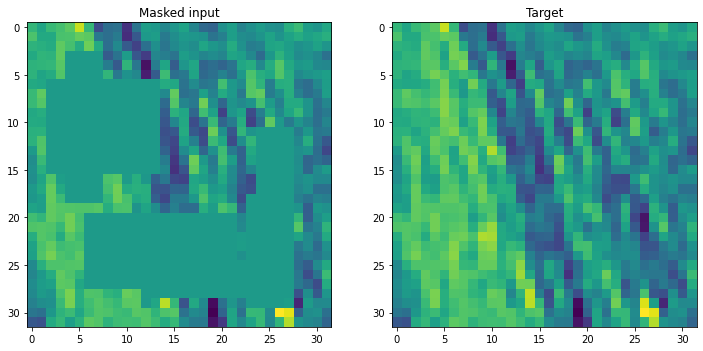

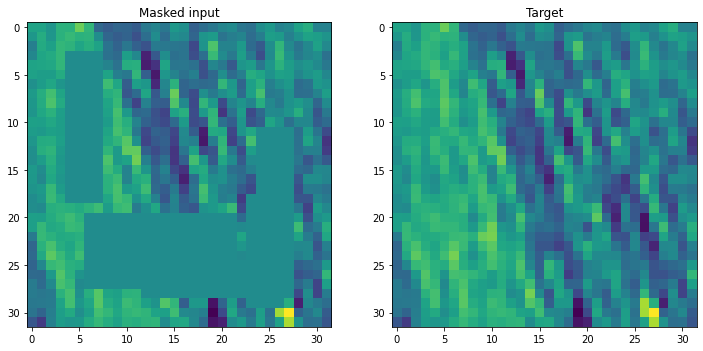

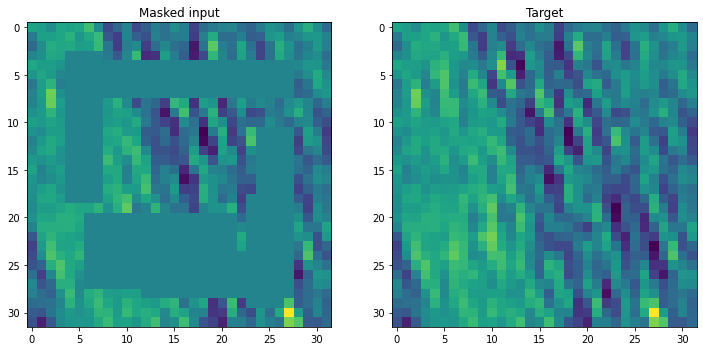

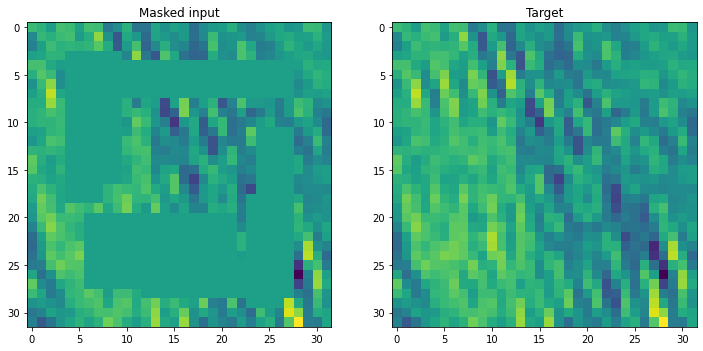

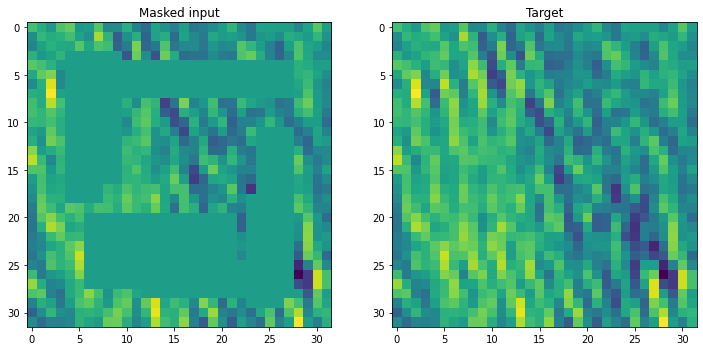

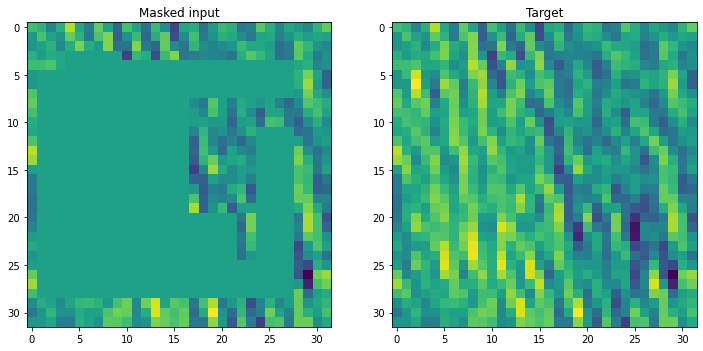

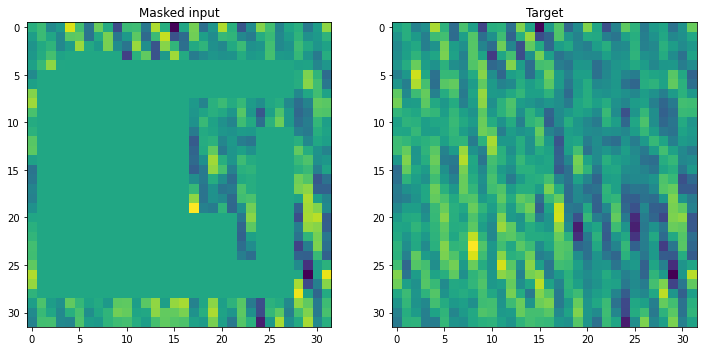

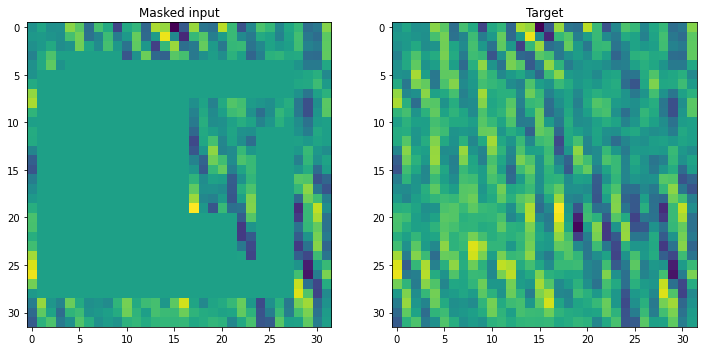

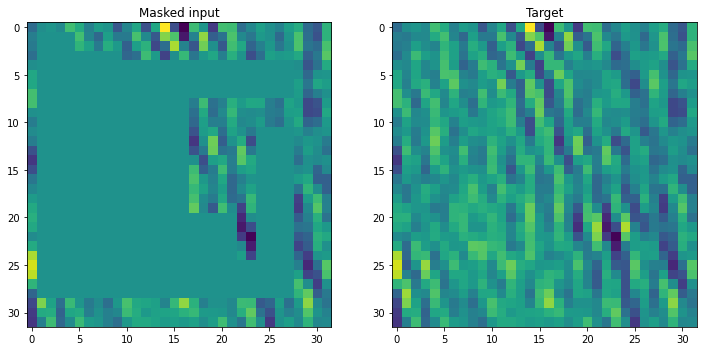

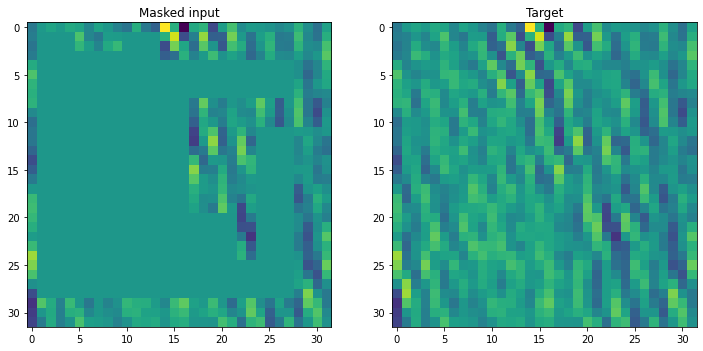

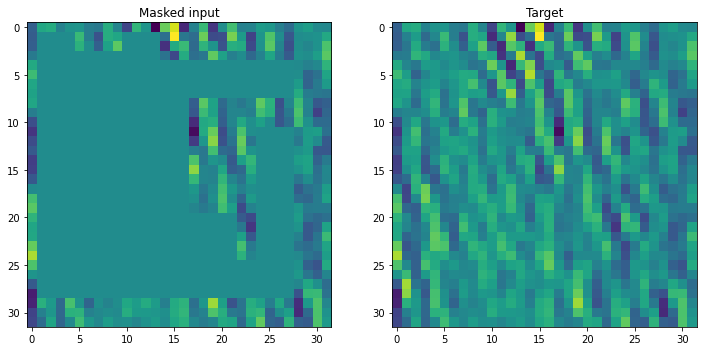

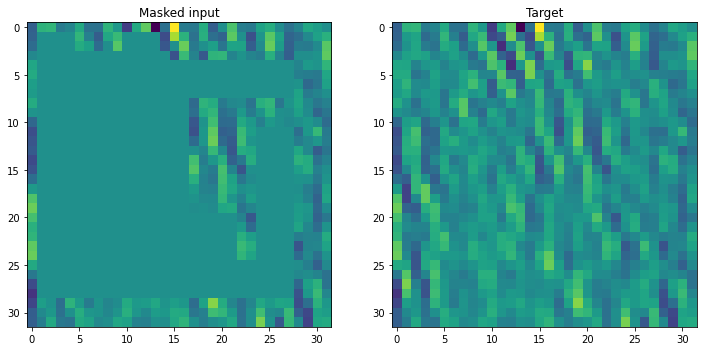

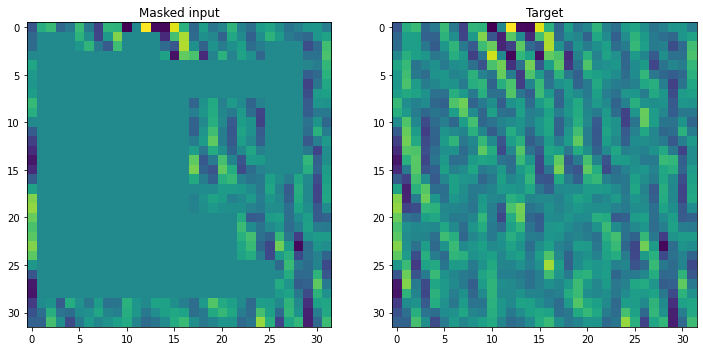

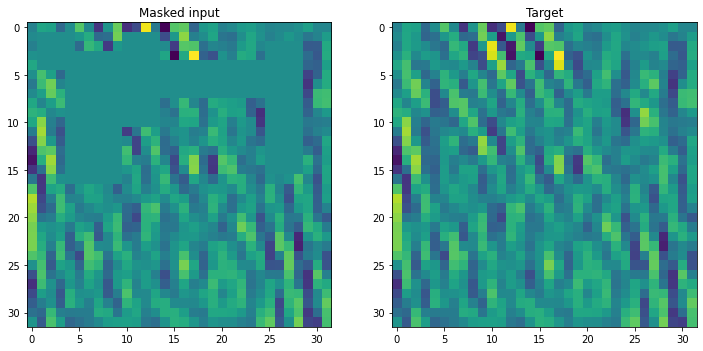

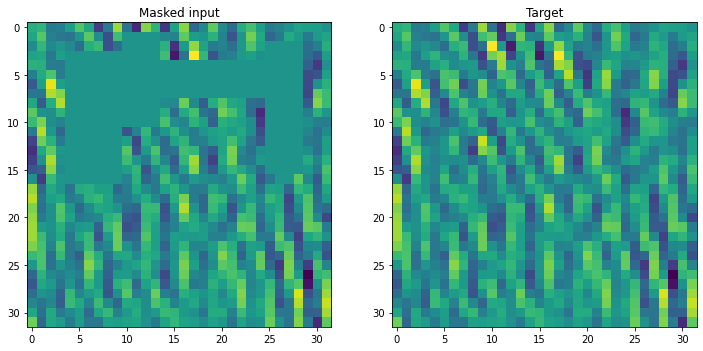

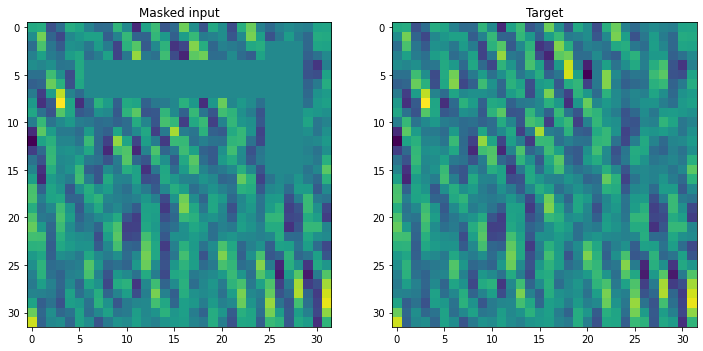

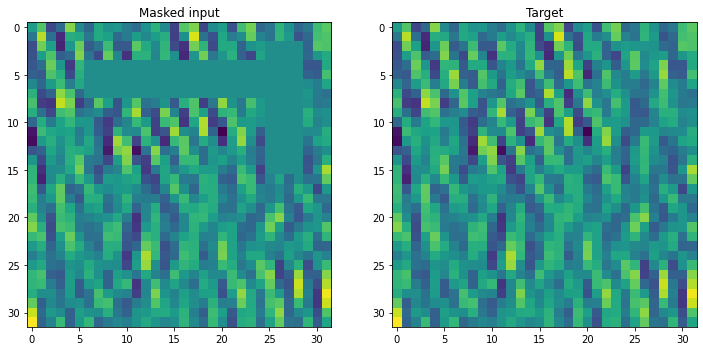

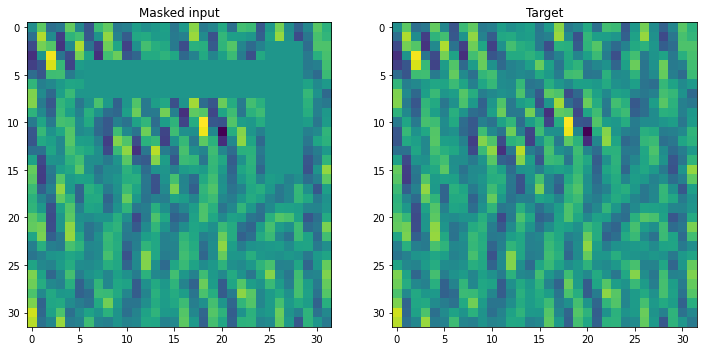

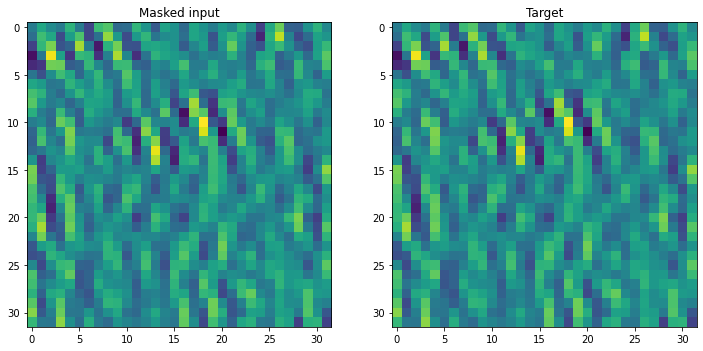

In [ ]:
dim_in = 32
mask_pct = 0.4

train_set = PretextDeepFinder_dataset(False, path_data, path_target, objl_train, dim_in, 0, 'dataset', mask_pct)
batch_data, batch_target = train_set.generate_batch_from_array(3)

sample_data = batch_data[0]
sample_target = batch_target[0]

z_idx = 15
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

ax1.imshow(sample_data[z_idx])
ax1.set_title('Masked input')
ax2.imshow(sample_target[z_idx])
ax2.set_title('Target')

plt.show()

In [10]:
n = int((batch_data.flatten() == 0).sum())
d = len(batch_data.flatten())
n/d

0.316497802734375

In [ ]:
batch_data2, batch_target2 = train_set.generate_batch_from_array(3)

In [255]:
def createRandomSquare(mask):
    """Create a random square within an existing mask."""
    
    z, y, x = mask.shape[1::]

    # Patches need to bee bigger than 12**3
    assert all(np.array([z, y, x])>12)

    z_c_bounds = [3, z-3]
    y_c_bounds = [3, y-3]
    x_c_bounds = [3, x-3]

    center = [np.random.randint(z_c_bounds[0], z_c_bounds[1]), np.random.randint(y_c_bounds[0], y_c_bounds[1]),
              np.random.randint(x_c_bounds[0], x_c_bounds[1])]

    z_c, y_c, x_c = center

    ############### number of pixels for each square is between bounds
    z_pixel_bounds = min([z_c, z-z_c])
    n_pixel_z = np.random.randint(2, z_pixel_bounds)

    y_pixel_bounds = min([y_c, y-y_c])
    n_pixel_y = np.random.randint(2, y_pixel_bounds)

    x_pixel_bounds = min([x_c, x-x_c])
    n_pixel_x = np.random.randint(2, x_pixel_bounds)
    
    ###############

    mask[0, z_c-n_pixel_z:z_c+n_pixel_z, y_c-n_pixel_y:y_c+n_pixel_y, x_c-n_pixel_x:x_c+n_pixel_x] = 0
    
    return mask

def createRandomSquareMask(img, max_mask_pct=0.3):
    """
    Incrementally create a random square mask where at most max_mask_pct of the pixels are missing.
    
    Shape of image is (C, Z, Y, X).
    """
    ## Prepare masking matrix
    mask = np.full(img.shape, 255) ## White background
    total_volume = img.shape[1]*img.shape[2]*img.shape[3]
    masked_volume = 0
    
    for _ in range(np.random.randint(5, 20)):
        if masked_volume > total_volume*max_mask_pct:
            break
        else:
            mask = createRandomSquare(mask)
            masked_volume = (mask[0]==0).sum()
            print(masked_volume)
    
    print("Total masked percentage: %f" %(100*masked_volume/total_volume))
        
    return torch.tensor(mask)

In [252]:
batch_data2, batch_target2 = train_set.generate_batch_from_array(3)
mask = createRandomSquareMask(batch_data2)

batch_target2[mask==0] = 0

batch_target2.shape

32768
[23, 7, 8]
96
[15, 12, 12]
1536
[6, 21, 12]
2616
[23, 8, 7]
3224
[11, 13, 11]
3466
[17, 27, 6]
4060
[19, 26, 9]
5124
[10, 28, 17]
6327
[8, 18, 23]
6889
[13, 3, 13]
7017
[19, 28, 12]
7098
Total masked percentage: 21.661377


torch.Size([1, 32, 32, 32])

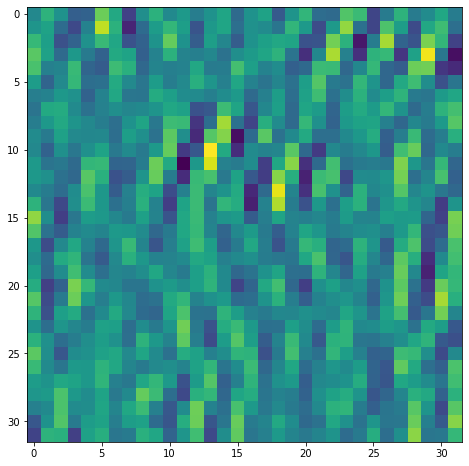

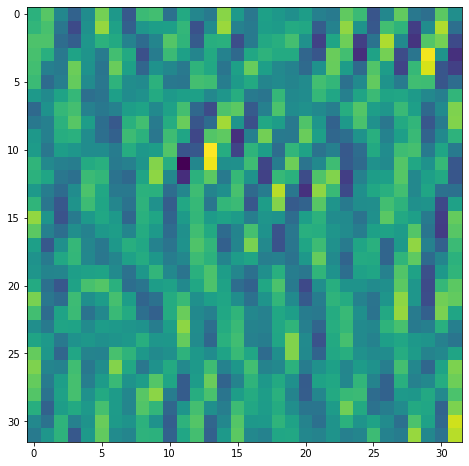

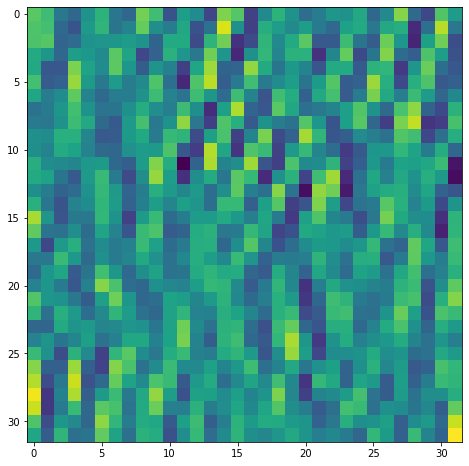

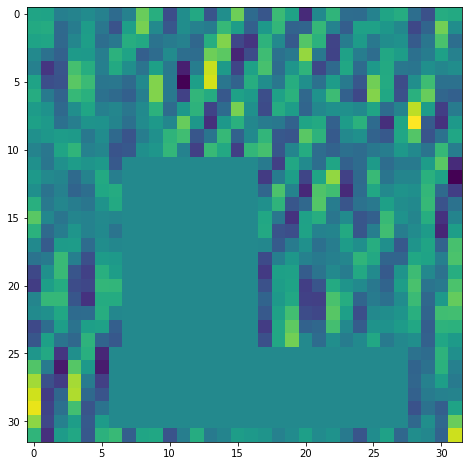

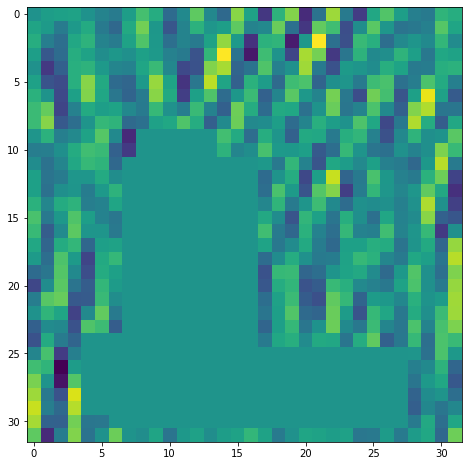

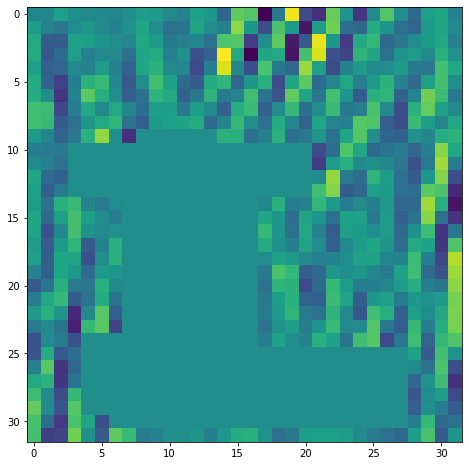

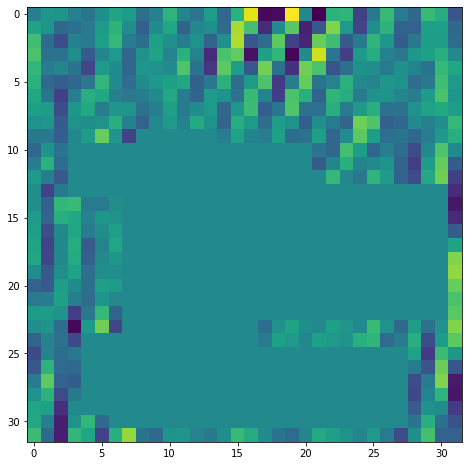

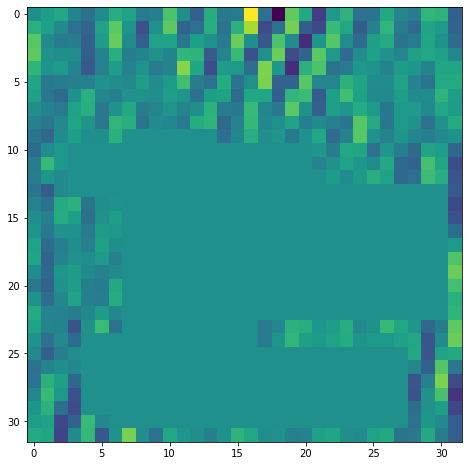

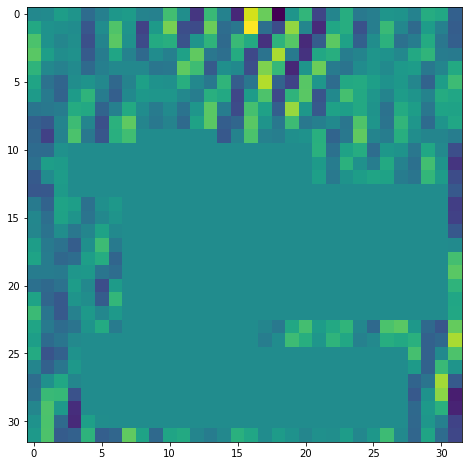

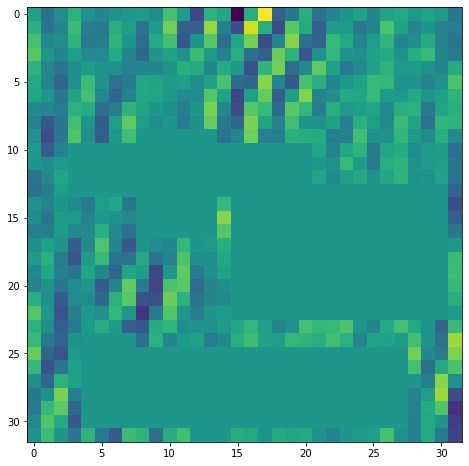

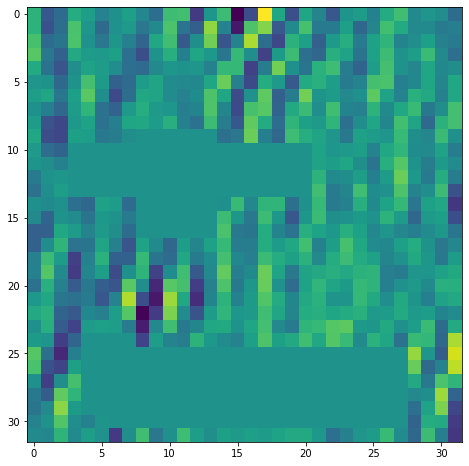

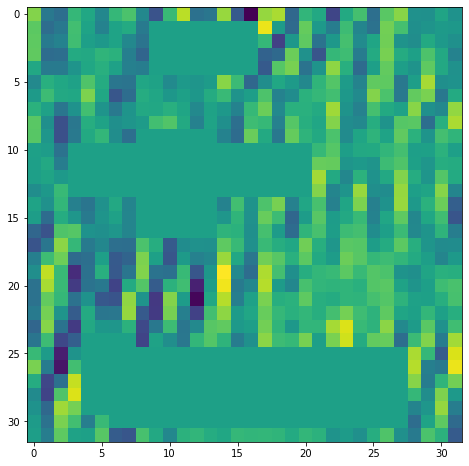

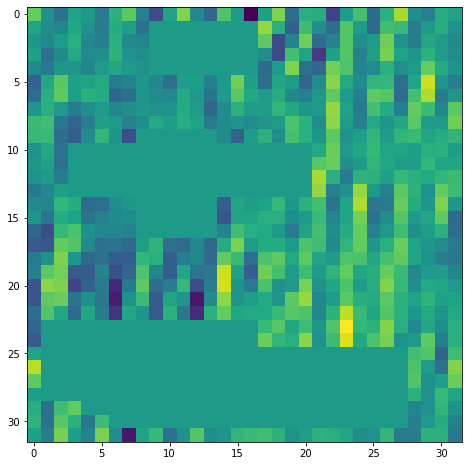

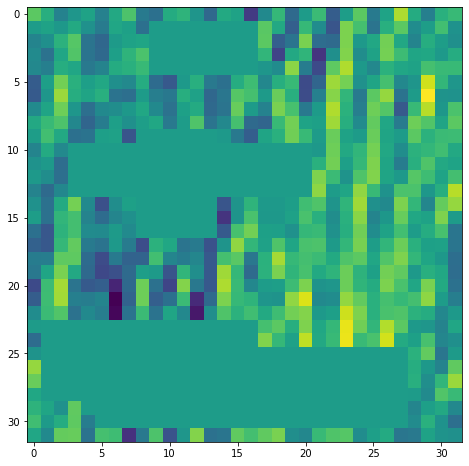

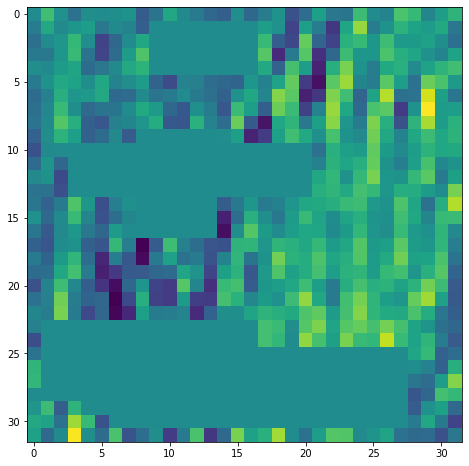

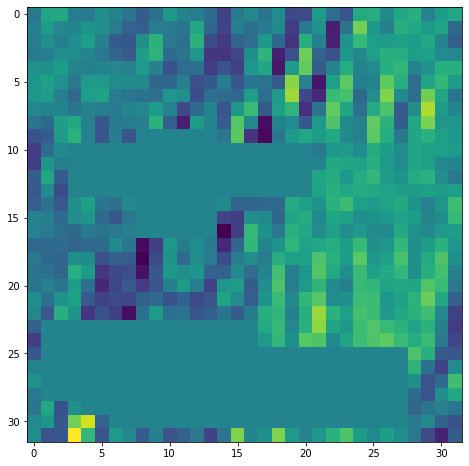

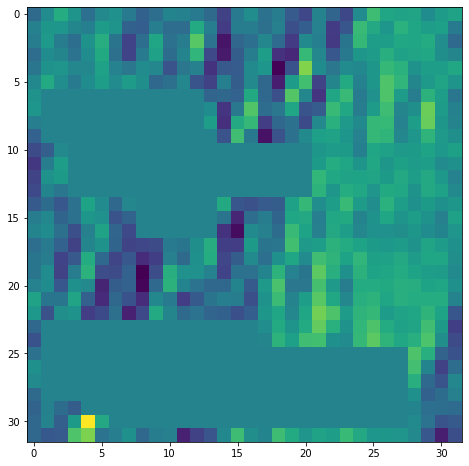

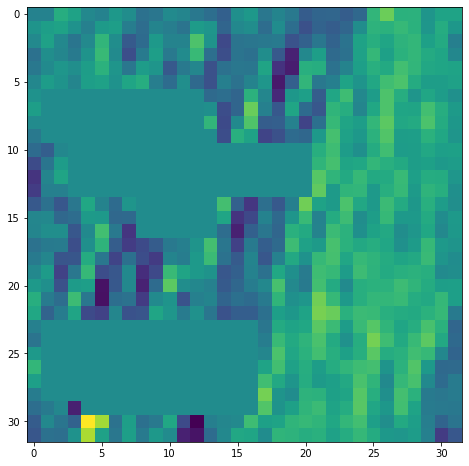

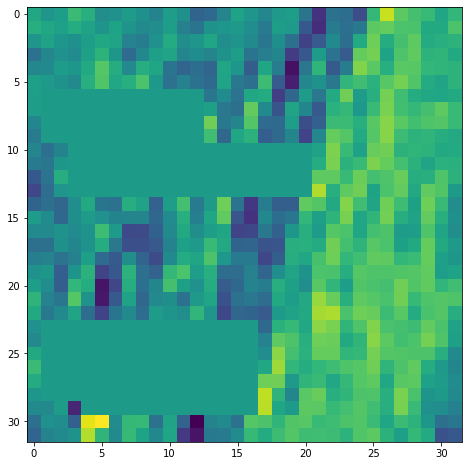

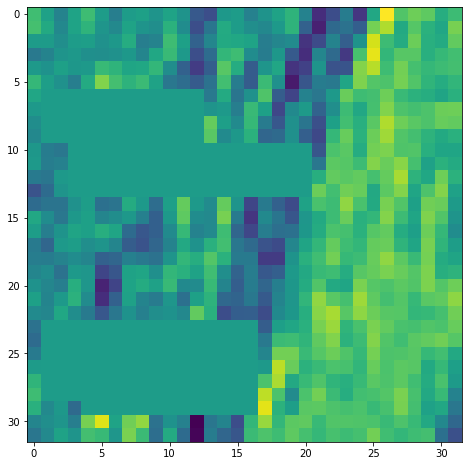

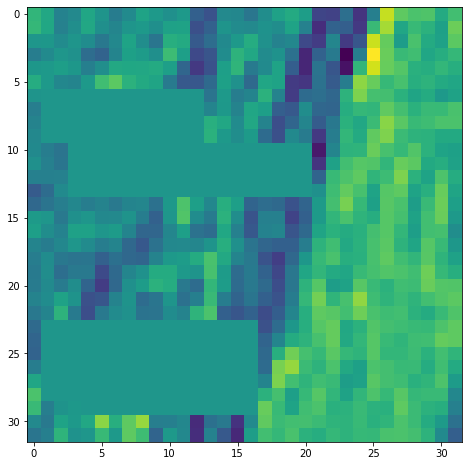

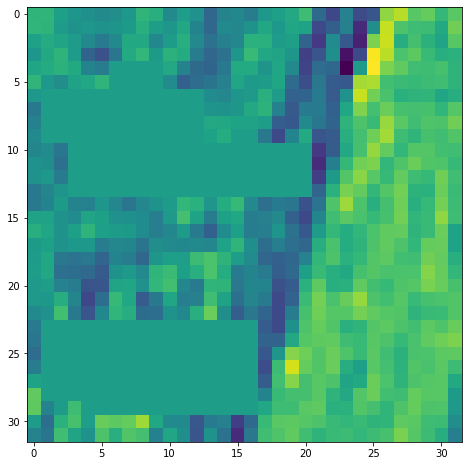

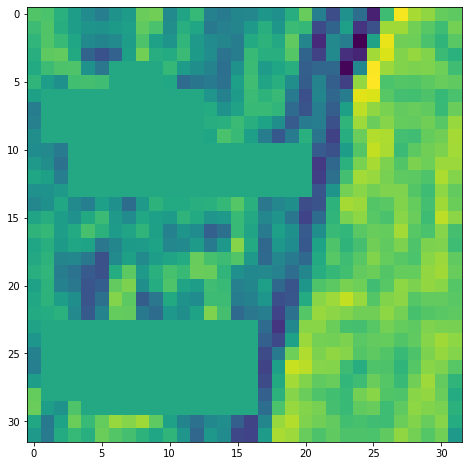

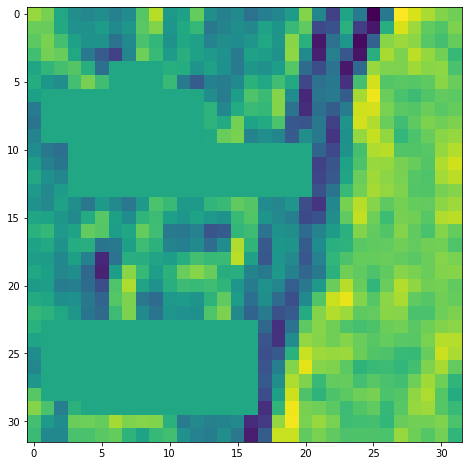

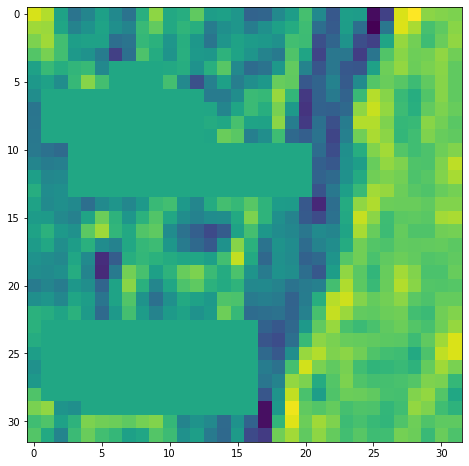

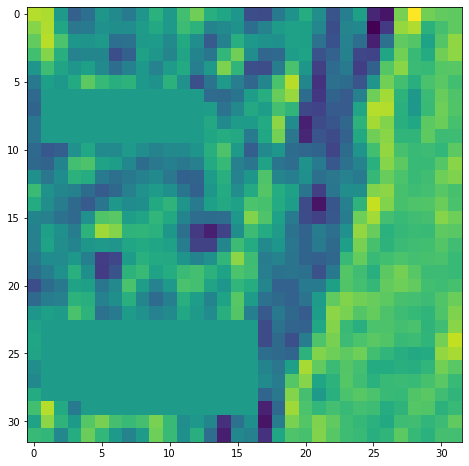

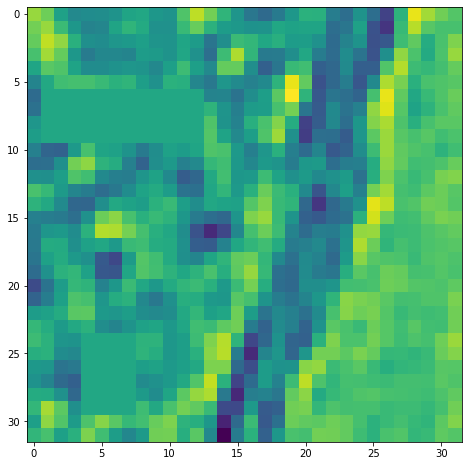

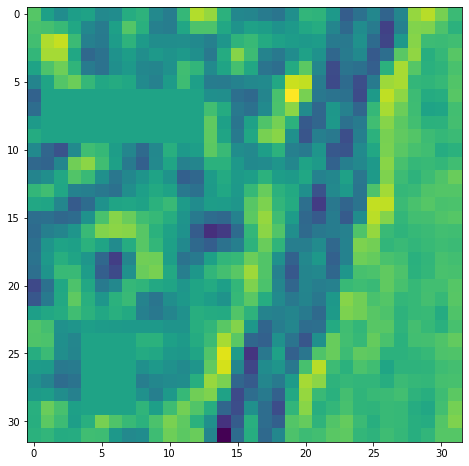

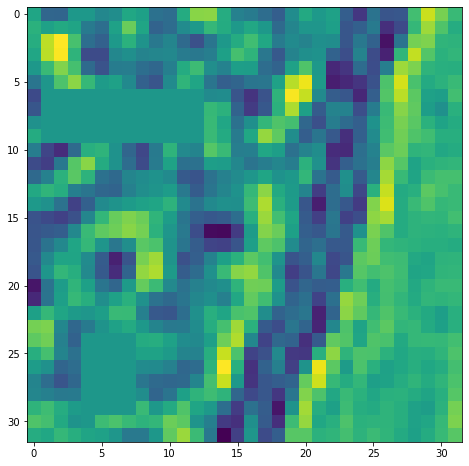

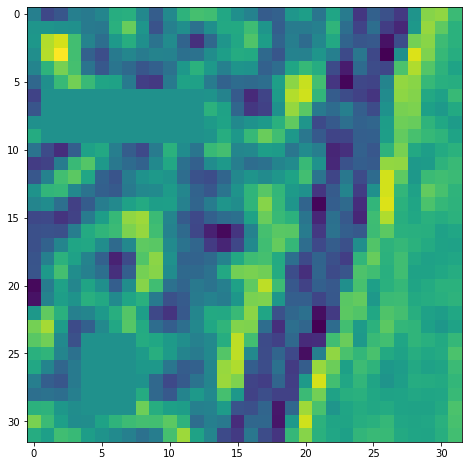

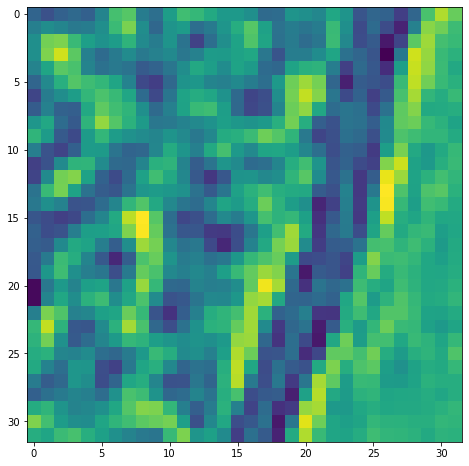

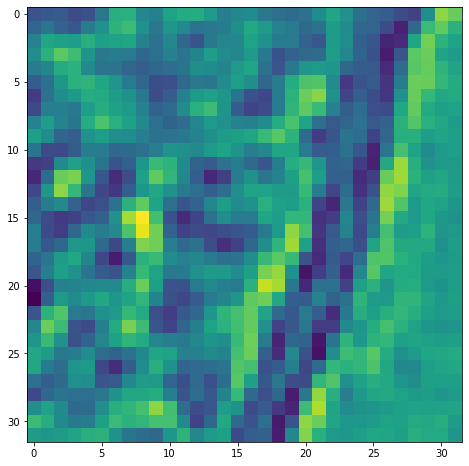

In [253]:
for z_idx in range(32):
    plt.figure(figsize=(8, 8))
    plt.imshow(batch_target2[0][z_idx])
    plt.show()

In [254]:
(mask[0]==0).sum()/32**3.

tensor(0.2166)

In [82]:
z_c-n_pixel_z,z_c+n_pixel_z, y_c-n_pixel_y,y_c+n_pixel_y, x_c-n_pixel_x,x_c+n_pixel_x

(4, 4, 4, 6, 9, 11)

In [81]:
mask[0, z_c-n_pixel_z:z_c+n_pixel_z, y_c-n_pixel_y:y_c+n_pixel_y, x_c-n_pixel_x:x_c+n_pixel_x]

array([], shape=(0, 2, 2), dtype=uint8)

[0.015384615384615385, 0.38461538461538464, 0.03076923076923077, 0.5692307692307692]
0.1976318359375
[[23, 10, 14], [15, 11, 12], [25, 10, 10], [16, 14, 11]]


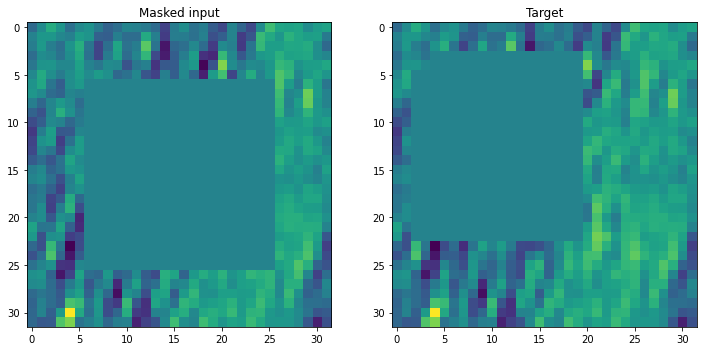

In [367]:
batch_data2, batch_target2 = train_set.generate_batch_from_array(3)

total_lost_pixels = (dim_in**3 * mask_pct)

n_centers = random.randint(3, 6)

small_centers = random.sample(range(1, n_centers), n_centers//2)
big_centers = random.sample(range(20, 50), n_centers-n_centers//2)

portion_per_patch = big_centers+small_centers
random.shuffle(portion_per_patch)

portion_per_patch = [x/sum(portion_per_patch) for x in portion_per_patch]

print(portion_per_patch)

pixels_per_patch = [int(np.round(total_lost_pixels*x)) for x in portion_per_patch]
patch_dims = np.round(np.power(pixels_per_patch, 1/3)/2)

adjust_missing_pixels = total_lost_pixels - np.power(patch_dims*2, 3).sum()



random_centers = []
for i in range(n_centers//2):
    
    n_pixel = int(patch_dims[i])
    
    z = random.randint(n_pixel, dim_in-n_pixel)
    y = random.randint(n_pixel, (dim_in-n_pixel)//2+1)
    x = random.randint(n_pixel, dim_in-n_pixel)
    
    random_centers.append([z, y, x])

    batch_target2[0, z-n_pixel:z+n_pixel, y-n_pixel:y+n_pixel, x-n_pixel:x+n_pixel] = 0
    
for i in range(n_centers//2, n_centers):
    
    n_pixel = int(patch_dims[i])
    
    z = random.randint(n_pixel, dim_in-n_pixel)
    y = random.randint(n_pixel, dim_in-n_pixel)
    x = random.randint(n_pixel, (dim_in-n_pixel)//2+1)
    
    random_centers.append([z, y, x])

    batch_target2[0, z-n_pixel:z+n_pixel, y-n_pixel:y+n_pixel, x-n_pixel:x+n_pixel] = 0


sample_data2 = batch_data2[0]
sample_target2 = batch_target2[0]

n = int((batch_target2.flatten() == 0).sum())
d = len(batch_target2.flatten())
print(n/d)

print(random_centers)

z_idx = z
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

ax1.imshow(sample_data2[z_idx])
ax1.set_title('Masked input')
ax2.imshow(sample_target2[z_idx])
ax2.set_title('Target')

plt.show()

# Model

In [28]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

class PretextDeepFinder_model(pl.LightningModule):

    def __init__(self, Ncl, loss_fn, lr, weight_decay, use_pretrained):
        super().__init__()
        self.Ncl = Ncl
        self.loss_fn = loss_fn
        self.use_pretrained = use_pretrained
        # self.loss_fn.to(self.device)
        self.lr = lr
        self.weight_decay = weight_decay
        self.epoch_acc_train = []
        self.epoch_loss_train = []
        self.epoch_acc_val = []
        self.epoch_loss_val = []
        self.save_hyperparameters()
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 32, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 32, (3, 3, 3), padding=1),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(32, 48, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(48, 48, (3, 3, 3), padding=1),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(48, 64, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 64, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 64, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 64, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 64, (2, 2, 2), stride=2),
            nn.Conv3d(64, 64, (3, 3, 3), padding=1)
        )
        self.layer4 = nn.Sequential(
            nn.Conv3d(64 + 48, 48, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(48, 48, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(48, 48, (2, 2, 2), stride=2),
            nn.Conv3d(48, 48, (3, 3, 3), padding=1)
        )
        self.layer5 = nn.Sequential(
            nn.Conv3d(48 + 32, 32, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 32, (3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 1, (1, 1, 1), padding=0),
            # nn.Softmax(dim=1)
        )


    def forward(self, x):
        x_high = self.layer1(x)
        mid = self.layer2(x_high)
        x = self.layer3(mid)
        x = torch.cat((mid, x), dim=1)
        x = self.layer4(x)
        x = torch.cat((x_high, x), dim=1)
        x = self.layer5(x)
        return x


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=self.weight_decay)
        return optimizer

    def training_step(self, batch, batch_idx):
        batch_data, batch_target = batch
        # batch_data = batch_data.to(self.device)
        # batch_target = batch_target.to(self.device)
        pred = self(batch_data)
        loss = self.loss_fn(pred, batch_target)
        self.log('hp/train loss', loss)
        self.epoch_loss_train.append(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        batch_data, batch_target = batch
        # batch_data = batch_data.to(self.device)
        # batch_target = batch_target.to(self.device)
        pred = self(batch_data)
        loss = self.loss_fn(pred, batch_target)
        self.log('hp/val loss', loss) 
        self.epoch_loss_val.append(loss)
        return loss


    def on_epoch_end(self):
        if len(self.epoch_acc_train) > 0:
            self.log('hp/train_loss_epoch', torch.mean(torch.Tensor(self.epoch_loss_train)))
        if len(self.epoch_acc_val) > 0:
            self.log('hp/val_loss_epoch', torch.mean(torch.Tensor(self.epoch_loss_val)))
        self.epoch_acc_train = []
        self.epoch_loss_train = []
        self.epoch_acc_val = []
        self.epoch_loss_val = []

    def on_train_start(self):
        self.logger.log_hyperparams(self.hparams, {"hp/train loss": 0, "hp/mean_pred": 0})
        print(self.hparams)

In [16]:
from deepfinder import losses_pylit

In [29]:
model = PretextDeepFinder_model(2, torch.nn.MSELoss(), 1e-4, 0, False) 

model(torch.as_tensor(batch_data).unsqueeze(0).detach()).shape

torch.Size([1, 1, 32, 32, 32])

# Load model

In [10]:
path_model = '/home/jeronimo/Desktop/Master_mathematics/Thesis/models/PretextDeepFindr_exp1.1_ep5000_in32_lr0.000050_v1.model'

pretrained_dict = torch.load(path_model)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k not in ['layer5.4.weight', 'layer5.4.bias']}
# Use regular initialization for the last layer, which are different in the reconstruction task
pretrained_dict['layer5.4.weight'] = model_dict['layer5.4.weight']
pretrained_dict['layer5.4.bias'] = model_dict['layer5.4.bias']


# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 


# 3. load the new state dict
model.load_state_dict(pretrained_dict)

OrderedDict([('layer1.0.weight',
              tensor([[[[[-1.9707e-01, -1.8960e-01,  1.9881e-02],
                         [ 7.1541e-02, -2.0039e-01,  4.4083e-02],
                         [-9.5331e-02, -1.3644e-01, -1.0826e-01]],
              
                        [[-9.3824e-02, -1.4494e-02, -1.6286e-01],
                         [ 1.3346e-01,  1.4936e-01,  1.3560e-01],
                         [-8.9035e-02, -1.6932e-02, -1.9106e-01]],
              
                        [[ 1.7860e-01,  1.4654e-01, -5.4188e-02],
                         [-1.2204e-01, -4.7812e-02,  4.5688e-02],
                         [-1.0816e-01,  4.4585e-03, -4.2001e-02]]]],
              
              
              
                      [[[[ 2.0551e-02, -1.1400e-01,  1.5127e-01],
                         [ 3.3258e-02,  1.1966e-01,  1.4153e-01],
                         [ 1.6128e-01,  6.8526e-03,  9.3539e-02]],
              
                        [[ 4.7915e-02, -1.7266e-01, -1.1169e-01],
             

In [11]:
model = DeepFinder_model(2, Tversky_loss(), 1e-4, 0, False)

<All keys matched successfully>